# UTILS-FC_COMPARISON_PIPELINE
This file illustrate the basic pipeline for reading data from the `strereoeeg_patients` folder.

In [1]:
# figures inline
%matplotlib inline
# import the lrgsglib package
from lrgsglib import move_to_rootf
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc.notebook import *
# Figure output path
path_data = Path('data')
path_seeg_data = path_data / 'strereoeeg_patients'
path_figs = path_data / 'figures' / 'UTILS-FILEREADER'
path_figs.mkdir(parents=True, exist_ok=True)
#

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


In [2]:
# data loader
data_dict, int_label_map = load_data_dict(pat_list=['Pat_02'])
print('✓ Data loaded')

✓ Data loaded


## Coherence-Based Functional Connectivity

Now let's demonstrate the coherence-based FC pipeline using magnitude-squared coherence (MSC) instead of correlation.

In [4]:
# Select a patient and phase for demonstration
patient_id = list(data_dict.keys())[0]  # First patient
phase = 'rsPre'  # Resting state pre-task

# Extract data
patient_data = data_dict[patient_id][phase]
X = patient_data['data']  # (N, L) array
fs = patient_data['fs'].squeeze()  # Sampling frequency

print(f'Patient: {patient_id}')
print(f'Phase: {phase}')
print(f'Data shape: {X.shape} (N channels, L samples)')
print(f'Sampling frequency: {fs} Hz')
print(f'Duration: {X.shape[1] / fs:.2f} seconds')

Patient: Pat_02
Phase: rsPre
Data shape: (117, 1323208) (N channels, L samples)
Sampling frequency: 2048 Hz
Duration: 646.10 seconds


### 1. Dense MSC (No Sparsification)

First, compute band-averaged magnitude-squared coherence without sparsification.

In [5]:
from lrg_eegfc.utils.coherence import coherence_fc_pipeline
from lrg_eegfc.config.const import BRAIN_BANDS

# Compute dense MSC matrices (no sparsification)
msc_matrices = coherence_fc_pipeline(
    X,
    fs,
    bands=BRAIN_BANDS,
    sparsify="none",  # No sparsification
    nperseg=512,      # Window length for spectral estimation
)

print('✓ Dense MSC matrices computed')
print(f'  Bands: {list(msc_matrices.keys())}')
print(f'  Matrix shape: {msc_matrices[list(msc_matrices.keys())[0]].shape}')
print(f'  Example (alpha band):')
print(f'    Mean MSC: {msc_matrices["alpha"].mean():.4f}')
print(f'    Max MSC: {msc_matrices["alpha"].max():.4f}')

✓ Dense MSC matrices computed
  Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']
  Matrix shape: (117, 117)
  Example (alpha band):
    Mean MSC: 0.0665
    Max MSC: 0.9812


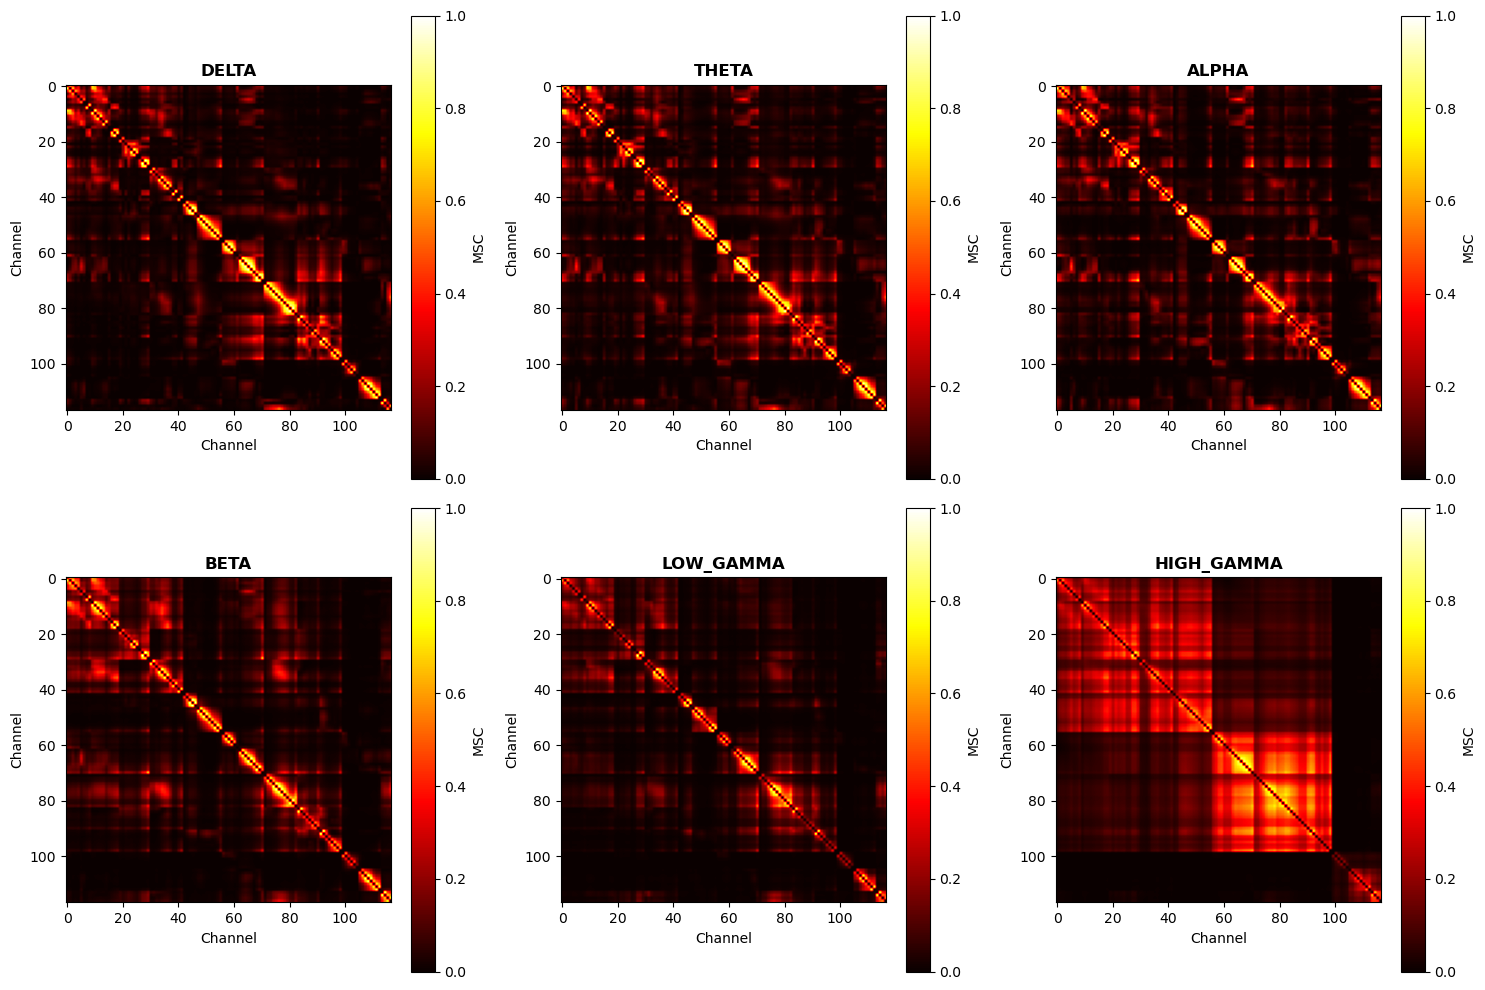

✓ Saved: data/figures/UTILS-FILEREADER/Pat_02_rsPre_msc_dense.png


In [6]:
# Visualize dense MSC matrices
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (band_name, W) in enumerate(msc_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(W, cmap='hot', vmin=0, vmax=1)
    ax.set_title(f'{band_name.upper()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='MSC')

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_msc_dense.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ Saved: {path_figs / f"{patient_id}_{phase}_msc_dense.png"}')

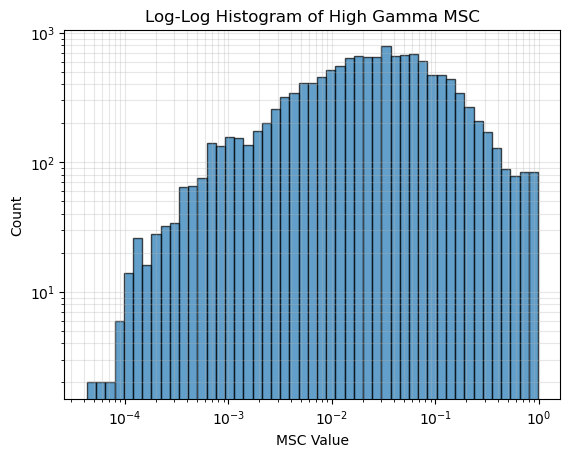

In [7]:
# Create logarithmic bins
data = msc_matrices['alpha'].flatten()
data_positive = data[data > 0]  # Remove zeros for log scale

# Create log-spaced bins
bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), 50)

# Plot histogram with log bins
plt.hist(data_positive, bins=bins, edgecolor='black', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MSC Value')
plt.ylabel('Count')
plt.title('Log-Log Histogram of High Gamma MSC')
plt.grid(True, alpha=0.3, which='both')

In [8]:
from lrgsglib import *

cc = msc_matrices['delta']
cc.shape
pin_labels = int_label_map['Pat_02']['label']
G, rnodes = get_giant_component_leftoff(nx.from_numpy_array(cc))
label_dict = {k: v for k, v in pin_labels.to_dict().items() if k not in rnodes}
spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
dists = squareform(Trho)
lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
optimal_clusters = fcluster(lnkgM, t=clTh, criterion='distance')

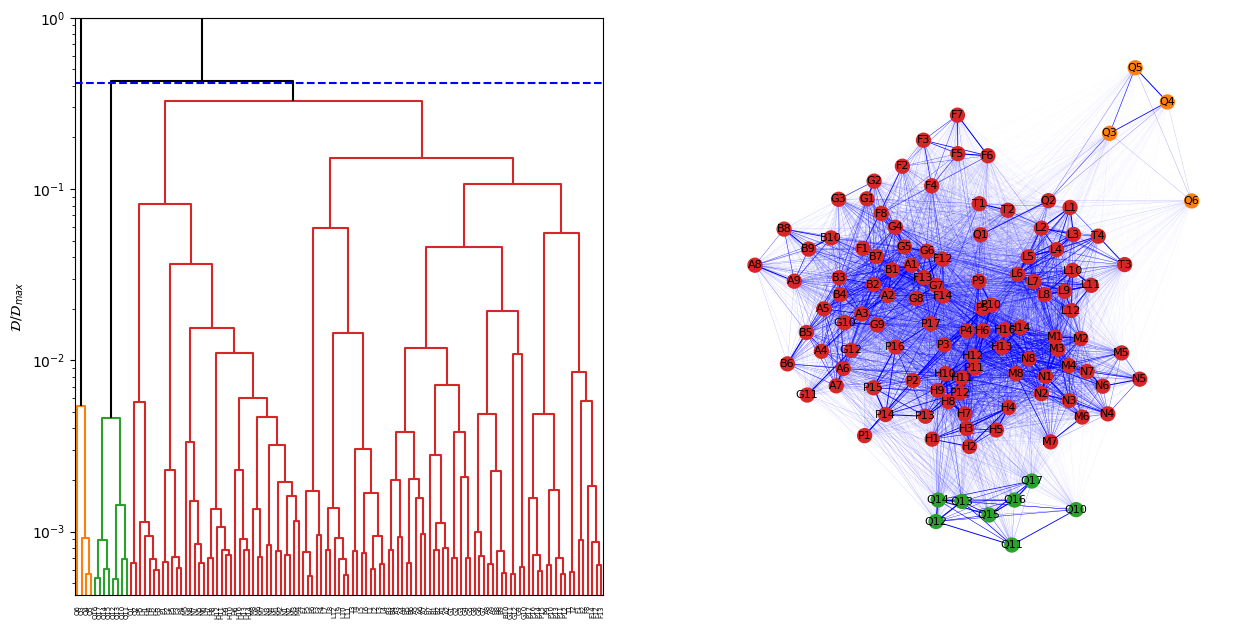

In [9]:
#
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')
#
node_list = list(G.nodes())
labels_for_dendro = [label_dict[n] for n in node_list]
#
widths = [G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['r' if d['weight'] < 0 else 'b' for _,_,d in G.edges(data=True)]
#
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
# Dendrogram first (to get the leaf colors)
dendro = dendrogram(
    lnkgM,
    ax=ax[0],
    color_threshold=clTh,
    labels=labels_for_dendro,
    **kw_dentro
)
# Get the leaf colors from dendrogram and map to nodes
zip_llb_col = zip(dendro['ivl'], dendro['leaves_color_list'])
leaf_label_colors = {lbl: col for lbl, col in zip_llb_col}
node_colors = [leaf_label_colors[label_dict[n]] for n in G.nodes()]
#
tmin = lnkgM[:, 2][0] * 0.8
tmax = lnkgM[:, 2][-1] * 1.01
ax[0].set_yscale('log')
ax[0].axhline(clTh, **kw_thline)
ax[0].set_ylim(tmin, tmax)
ax[0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
#
pos = nx.spring_layout(G)
#
nx.draw(
    G, ax=ax[1],
    width=widths,
    edge_color=edge_colors, 
    labels=label_dict,
    node_color=node_colors,
    pos=pos,
    **kw_draw_graph
)

### 2. Soft Sparsification with Surrogates

Apply soft sparsification using circular shift surrogates to downweight non-significant edges.

**Note:** This uses 50 surrogates for quick testing. For final analysis, use 200 surrogates.

In [11]:
# Compute soft-sparsified adjacency matrices
adj_matrices = coherence_fc_pipeline(
    X,
    fs,
    bands=BRAIN_BANDS,
    n_surrogates=1,   # Use 200 for final analysis
    sparsify="soft",   # Soft sparsification
    nperseg=256,
    zero_diagonal=True,
)

print('✓ Soft-sparsified adjacency matrices computed')
print(f'  Bands: {list(adj_matrices.keys())}')
print(f'  Matrix shape: {adj_matrices[list(adj_matrices.keys())[0]].shape}')

# Compare sparsity levels
for band_name in BRAIN_BANDS.keys():
    W = msc_matrices[band_name]
    A = adj_matrices[band_name]
    
    # Count near-zero edges
    N = W.shape[0]
    triu_idx = np.triu_indices(N, k=1)
    
    W_values = W[triu_idx]
    A_values = A[triu_idx]
    
    sparsity = (A_values < 0.01).sum() / len(A_values) * 100
    
    print(f'  {band_name:12s}: Mean Dense={W_values.mean():.4f}, Mean Sparse={A_values.mean():.4f}, Sparsity={sparsity:.1f}%')

✓ Soft-sparsified adjacency matrices computed
  Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']
  Matrix shape: (117, 117)
  delta       : Mean Dense=0.0598, Mean Sparse=0.0000, Sparsity=100.0%
  theta       : Mean Dense=0.0674, Mean Sparse=0.0579, Sparsity=38.7%
  alpha       : Mean Dense=0.0671, Mean Sparse=0.0579, Sparsity=38.7%
  beta        : Mean Dense=0.0638, Mean Sparse=0.0620, Sparsity=31.3%
  low_gamma   : Mean Dense=0.0468, Mean Sparse=0.0472, Sparsity=42.6%
  high_gamma  : Mean Dense=0.1374, Mean Sparse=0.1359, Sparsity=24.8%


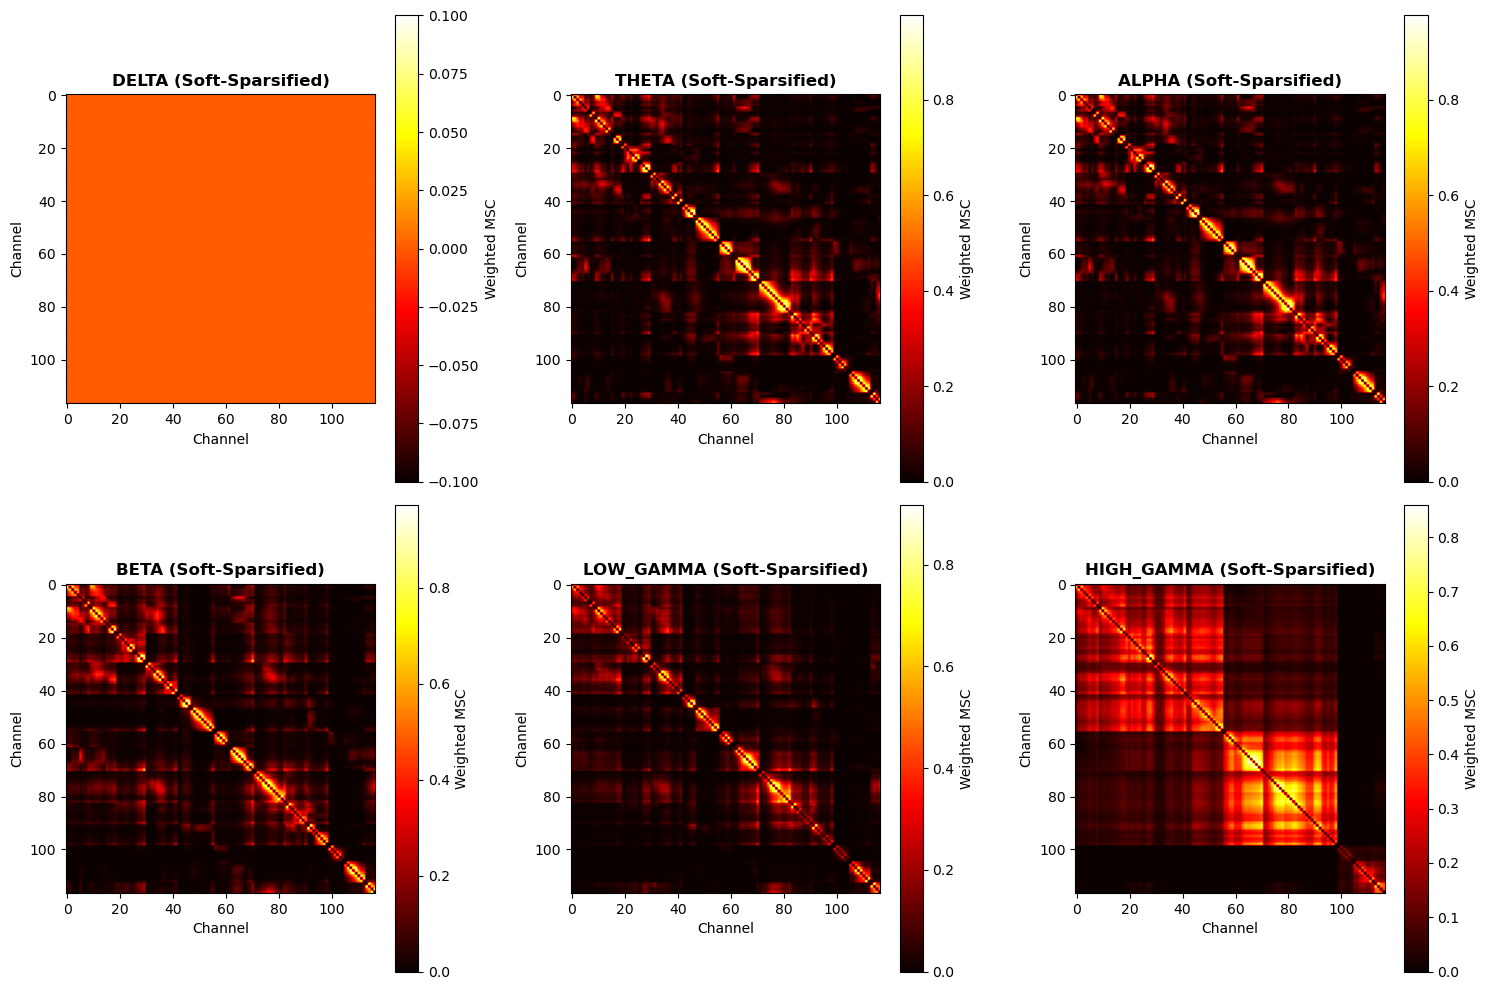

✓ Saved: data/figures/UTILS-FILEREADER/Pat_02_rsPre_msc_soft_sparsified.png


In [12]:
# Visualize soft-sparsified adjacency matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (band_name, A) in enumerate(adj_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(A, cmap='hot', vmin=0, vmax=np.max(A))
    ax.set_title(f'{band_name.upper()} (Soft-Sparsified)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='Weighted MSC')

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_msc_soft_sparsified.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ Saved: {path_figs / f"{patient_id}_{phase}_msc_soft_sparsified.png"}')

### 3. Compare Dense vs Sparse Distributions

Compare the weight distributions before and after soft sparsification for the alpha band.

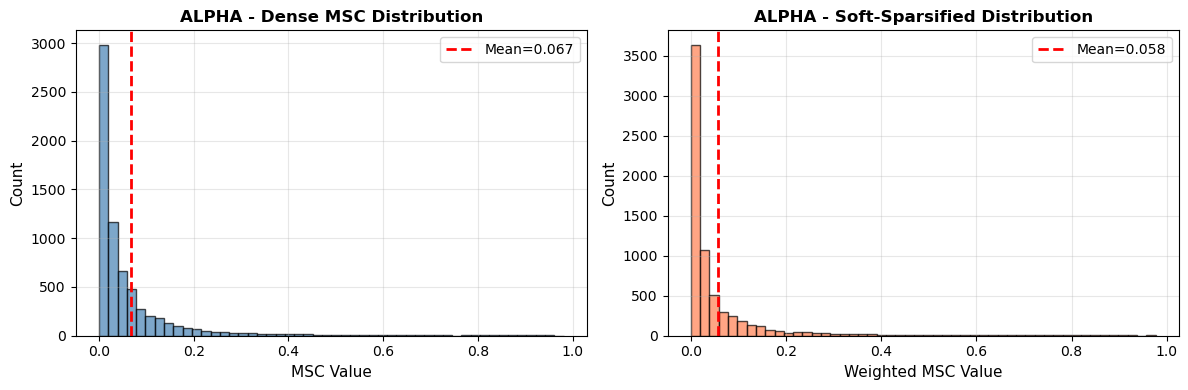

✓ Comparison for alpha band
  Dense MSC - Mean: 0.0671, Std: 0.1208
  Soft-Sparsified - Mean: 0.0579, Std: 0.1202
  Sparsity (edges < 0.01): 38.7%


In [13]:
# Compare for alpha band
band = 'alpha'

# Extract upper triangular values (excluding diagonal)
N = msc_matrices[band].shape[0]
triu_idx = np.triu_indices(N, k=1)

W_values = msc_matrices[band][triu_idx]
A_values = adj_matrices[band][triu_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of dense MSC
axes[0].hist(W_values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('MSC Value', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title(f'{band.upper()} - Dense MSC Distribution', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axvline(W_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={W_values.mean():.3f}')
axes[0].legend()

# Histogram of soft-sparsified
axes[1].hist(A_values, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Weighted MSC Value', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title(f'{band.upper()} - Soft-Sparsified Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axvline(A_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={A_values.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_{band}_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ Comparison for {band} band')
print(f'  Dense MSC - Mean: {W_values.mean():.4f}, Std: {W_values.std():.4f}')
print(f'  Soft-Sparsified - Mean: {A_values.mean():.4f}, Std: {A_values.std():.4f}')
print(f'  Sparsity (edges < 0.01): {(A_values < 0.01).sum() / len(A_values) * 100:.1f}%')

### 4. Integration with LRG Analysis

The coherence-based adjacency matrices have the same format as correlation-based FC, so they can be directly used with LRG ultrametric analysis and clustering functions from `lrgsglib`.

In [14]:
# Example: The adjacency matrices are ready for LRG analysis
print('✓ Coherence-based FC pipeline complete!')
print('')
print('Available adjacency matrices:')
for band_name in adj_matrices.keys():
    A = adj_matrices[band_name]
    n_edges = (A > 0.01).sum() // 2  # Count significant edges (upper triangle)
    print(f'  {band_name:12s}: {A.shape[0]:3d} nodes, ~{n_edges:4d} edges (threshold=0.01)')

print('')
print('These adjacency matrices can be used with:')
print('  - lrgsglib.utils.lrg.clustering functions')
print('  - lrgsglib.utils.lrg.spectral functions')  
print('  - Ultrametric distance comparisons (linalg.py)')
print('  - Hierarchical clustering analysis')
print('')
print('Next steps:')
print('  - Apply to all patients and phases')
print('  - Compare with correlation-based FC')
print('  - Use with LRG ultrametric tree analysis')

✓ Coherence-based FC pipeline complete!

Available adjacency matrices:
  delta       : 117 nodes, ~   0 edges (threshold=0.01)
  theta       : 117 nodes, ~4163 edges (threshold=0.01)
  alpha       : 117 nodes, ~4163 edges (threshold=0.01)
  beta        : 117 nodes, ~4660 edges (threshold=0.01)
  low_gamma   : 117 nodes, ~3894 edges (threshold=0.01)
  high_gamma  : 117 nodes, ~5106 edges (threshold=0.01)

These adjacency matrices can be used with:
  - lrgsglib.utils.lrg.clustering functions
  - lrgsglib.utils.lrg.spectral functions
  - Ultrametric distance comparisons (linalg.py)
  - Hierarchical clustering analysis

Next steps:
  - Apply to all patients and phases
  - Compare with correlation-based FC
  - Use with LRG ultrametric tree analysis
